In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ot
from scipy.optimize import linear_sum_assignment

In [2]:
rng = np.random.default_rng(42)

# -------- 1) Make a toy set of "error vectors" in R^2 --------
n =50
# Two mildly anisotropic blobs near the origin, plus a couple of outliers
# blob1 = rng.normal(loc=[0.2, 0.1], scale=[0.25, 0.15], size=(n//2, 2))
# blob2 = rng.normal(loc=[-0.1, -0.15], scale=[0.15, 0.25], size=(n - n//2 - 2, 2))
# outliers = rng.normal(loc=[0.8, 0.6], scale=[0.05, 0.05], size=(2, 2))
# X = np.vstack([blob1, blob2, outliers])

# Create n samples along the line x=y
t = np.linspace(-1, 1, n)  # parameter along the line
X = np.column_stack([t, t])  # points on the line x=y


In [3]:
# -------- 2) Build a quasi-uniform grid on the unit disk (target of MK ranks) --------
# Use a Fermat spiral in the unit disk (equal-area via r = sqrt(u))
phi = (1 + 5**0.5) / 2  # golden ratio
indices = np.arange(1, n + 1)
r = np.sqrt(indices / (n + 1.0))
theta = 2 * np.pi * indices / (phi**2)
U = np.column_stack([r * np.cos(theta), r * np.sin(theta)])  # target points on unit disk

In [4]:
print(X.shape), print(U.shape)

(50, 2)
(50, 2)


(None, None)

In [5]:
# -------- 3) Compute cost matrix (squared Euclidean) --------
def cdist2(A, B):
    # squared Euclidean distance matrix
    A2 = np.sum(A**2, axis=1)[:, None]
    B2 = np.sum(B**2, axis=1)[None, :]
    return A2 + B2 - 2 * A @ B.T

C = cdist2(X, U)

In [6]:
# -------- 4) Solve the discrete OT/assignment --------
# Uniform masses
a = np.ones(n) / n
b = np.ones(n) / n

pairs = None  # list of (i,j)
plan = None   # transport plan if available

# Try exact EMD first (returns an optimal transport plan)
try:
    plan = ot.emd(a, b, C)
    # Extract permutation from the plan (emd should yield a one-to-one matching here)
    rows, cols = np.where(plan > plan.max() * 1e-12)  # guard against tiny numerical zeros
    pairs = list(zip(rows.tolist(), cols.tolist()))
    # If for any reason it's not one-to-one, fall back below
    if len(pairs) != n:
        pairs = None
except Exception:
    plan = None
    pairs = None

# Fall back to SciPy's Hungarian method if needed
if pairs is None:
    row_ind, col_ind = linear_sum_assignment(C)
    pairs = list(zip(row_ind.tolist(), col_ind.tolist()))

# Final fallback: greedy minimal matching (not guaranteed optimal but fine for toy)
if pairs is None:
    flat_idx = np.argsort(C.ravel())
    used_rows = set()
    used_cols = set()
    pairs = []
    for k in flat_idx:
        i = k // n
        j = k % n
        if i not in used_rows and j not in used_cols:
            pairs.append((i, j))
            used_rows.add(i)
            used_cols.add(j)
            if len(pairs) == n:
                break

In [16]:
plan

array([[0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.02, 0.  ],
       ...,
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.02]], shape=(50, 50))

In [7]:
# Sanity: sort pairs by row index for consistent plotting order
pairs.sort(key=lambda p: p[0])

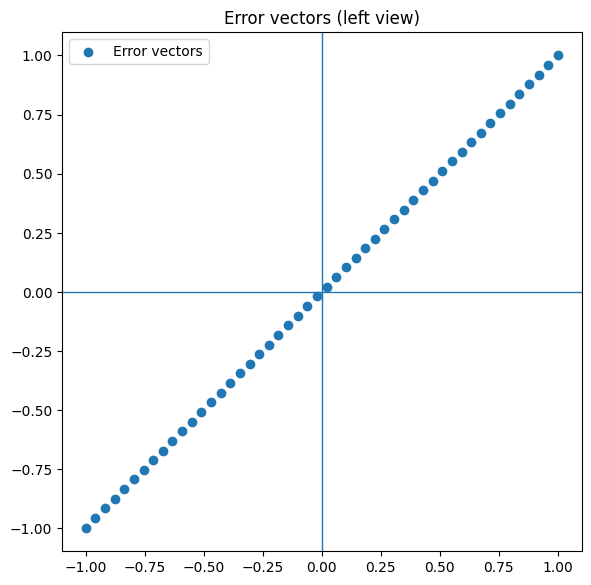

In [8]:
# -------- 5) Figures --------

# Figure A: Left — error vectors only
plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], marker='o', label='Error vectors')
plt.axhline(0, linewidth=1)
plt.axvline(0, linewidth=1)
plt.gca().set_aspect('equal', adjustable='box')
plt.title("Error vectors (left view)")
plt.legend(loc='best')
plt.tight_layout()
# plt.savefig('/mnt/data/mk_left.png', dpi=150)
plt.show()

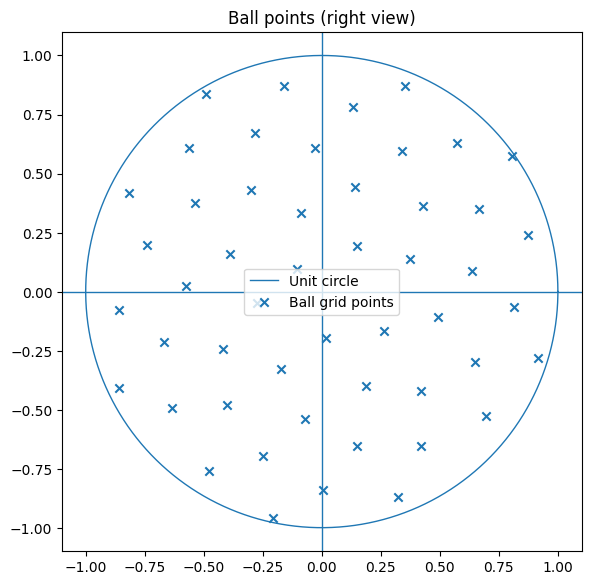

In [9]:
# Figure B: Right — unit-disk target points only (with boundary)
plt.figure(figsize=(6, 6))
# Unit circle
theta_c = np.linspace(0, 2*np.pi, 400)
plt.plot(np.cos(theta_c), np.sin(theta_c), linewidth=1, label='Unit circle')
plt.scatter(U[:, 0], U[:, 1], marker='x', label='Ball grid points')
plt.axhline(0, linewidth=1)
plt.axvline(0, linewidth=1)
plt.gca().set_aspect('equal', adjustable='box')
plt.title("Ball points (right view)")
plt.legend(loc='best')
plt.tight_layout()
# plt.savefig('/mnt/data/mk_right.png', dpi=150)
plt.show()

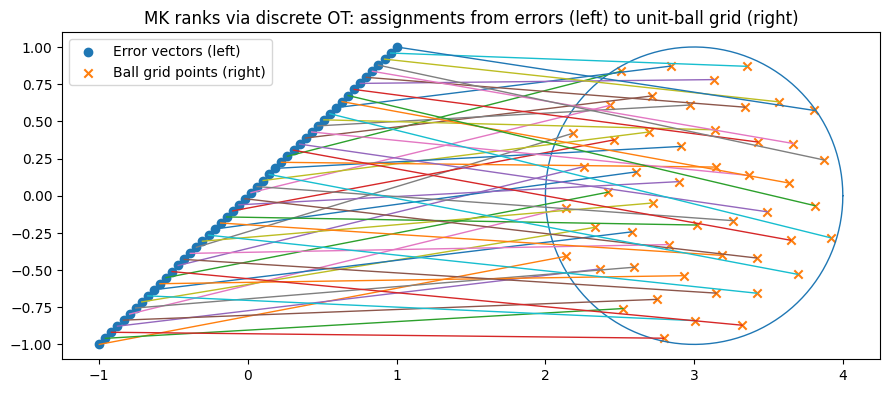

In [10]:
# Figure C: Combined — left vs right (shift right cloud), with arrows showing assignments
shift = np.array([3.0, 0.0])  # shift the right-hand side to the right

plt.figure(figsize=(9, 6))
# Left scatter
plt.scatter(X[:, 0], X[:, 1], marker='o', label='Error vectors (left)')
# Right scatter (shifted)
U_shift = U + shift
plt.scatter(U_shift[:, 0], U_shift[:, 1], marker='x', label='Ball grid points (right)')

# Unit circle (shifted)
plt.plot(np.cos(theta_c) + shift[0], np.sin(theta_c) + shift[1], linewidth=1)

# Draw assignment arrows; rely on default colors (no explicit colors specified)
for i, j in pairs:
    x0, y0 = X[i]
    x1, y1 = U_shift[j]
    # small markers to emphasize endpoints for each arrow (defaults ensure consistent styling)
    plt.plot([x0, x1], [y0, y1], linewidth=1)
    # (No explicit color set; using defaults as required.)

plt.gca().set_aspect('equal', adjustable='box')
plt.title("MK ranks via discrete OT: assignments from errors (left) to unit-ball grid (right)")
plt.legend(loc='best')
plt.tight_layout()
# plt.savefig('/mnt/data/mk_assignment.png', dpi=150)
plt.show()

# Save mapping pairs and radii as a small CSV for reference
rho = np.linalg.norm(U, axis=1)
mapping = np.array([(i, j, rho[j]) for (i, j) in pairs], dtype=float)
# np.savetxt('/mnt/data/mk_pairs.csv', mapping, delimiter=',', header='row_i,col_j,rho_of_target', comments='')

# print("Files written:")
# print(" - /mnt/data/mk_left.png")
# print(" - /mnt/data/mk_right.png")
# print(" - /mnt/data/mk_assignment.png")
# print(" - /mnt/data/mk_pairs.csv")

In [11]:
rho

array([0.14002801, 0.19802951, 0.24253563, 0.28005602, 0.31311215,
       0.34299717, 0.37047929, 0.39605902, 0.42008403, 0.44280744,
       0.46442036, 0.48507125, 0.50487816, 0.52393683, 0.54232614,
       0.56011203, 0.57735027, 0.59408853, 0.61036794, 0.62622429,
       0.64168895, 0.65678958, 0.67155074, 0.68599434, 0.70014004,
       0.71400555, 0.72760688, 0.74095857, 0.7540739 , 0.76696499,
       0.77964295, 0.79211803, 0.80439967, 0.81649658, 0.82841687,
       0.84016805, 0.85175712, 0.86319062, 0.87447463, 0.88561489,
       0.89661673, 0.90748521, 0.91822506, 0.92884073, 0.93933644,
       0.94971616, 0.95998366, 0.9701425 , 0.98019606, 0.99014754])

In [12]:
# --- 5) Build the rank radius per point ---
rho_assigned = np.zeros(n)
for i, j in pairs:
    rho_assigned[i] = rho[j]

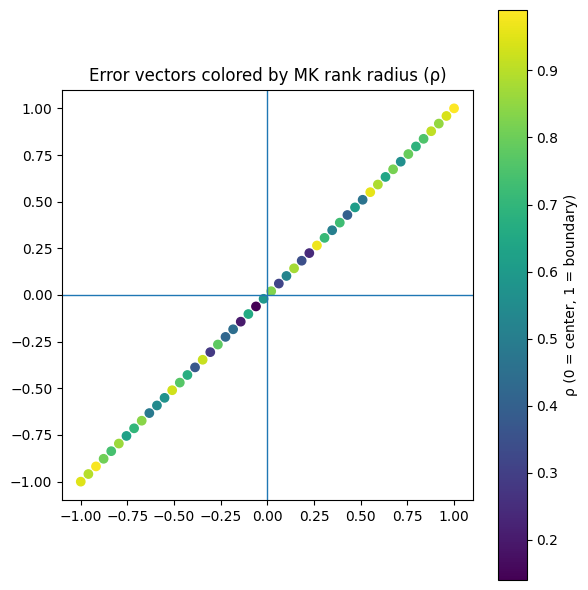

In [13]:
# --- 6) Plot: initial points colored by ρ ---
plt.figure(figsize=(6, 6))
sc = plt.scatter(X[:, 0], X[:, 1], c=rho_assigned)
plt.axhline(0, linewidth=1)
plt.axvline(0, linewidth=1)
plt.gca().set_aspect('equal', adjustable='box')
plt.title("Error vectors colored by MK rank radius (ρ)")
cbar = plt.colorbar(sc)
cbar.set_label("ρ (0 = center, 1 = boundary)")
plt.tight_layout()
# plt.savefig('/mnt/data/mk_ranked_points.png', dpi=150)
plt.show()

# print("Saved figure: /mnt/data/mk_ranked_points.png")

In [14]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(123)

def sinkhorn(a, b, C, eps, max_iters=1000, tol=1e-9):
    # Standard multiplicative Sinkhorn in the primal (not log-domain).
    # Works fine for moderate sizes and not-too-small eps.
    K = np.exp(-C / max(eps, 1e-12))
    u = np.ones_like(a)
    v = np.ones_like(b)
    # Avoid division by tiny numbers
    for _ in range(max_iters):
        u_prev = u.copy()
        Ku = K @ v
        u = a / np.maximum(Ku, 1e-300)
        Kv = K.T @ u
        v = b / np.maximum(Kv, 1e-300)
        if np.max(np.abs(u - u_prev)) < tol:
            break
    P = (u[:, None] * K) * v[None, :]
    return P

def barycentric(P, Y):
    rowsum = P.sum(axis=1, keepdims=True) + 1e-12
    return (P @ Y) / rowsum

def rotation_matrix(theta):
    c, s = np.cos(theta), np.sin(theta)
    return np.array([[c, -s], [s,  c]])

def set_equal_with_padding(ax, X, pad_frac=0.05):
    x_min, x_max = np.min(X[:,0]), np.max(X[:,0])
    y_min, y_max = np.min(X[:,1]), np.max(X[:,1])
    dx = x_max - x_min; dy = y_max - y_min
    if dx <= 1e-9 and dy <= 1e-9: dx = dy = 1.0
    if dx <= 1e-9: dx = max(1e-3, 0.1 * dy)
    if dy <= 1e-9: dy = max(1e-3, 0.1 * dx)
    ax.set_xlim(x_min - pad_frac*dx, x_max + pad_frac*dx)
    ax.set_ylim(y_min - pad_frac*dy, y_max + pad_frac*dy)
    ax.set_aspect('equal', adjustable='box')

def spearman_r(x, y):
    # Simple rank-correlation without SciPy
    def ranks(v):
        order = np.argsort(v)
        r = np.empty_like(order, dtype=float)
        r[order] = np.arange(1, len(v)+1)
        return r
    rx, ry = ranks(x), ranks(y)
    rx = (rx - rx.mean()) / rx.std()
    ry = (ry - ry.mean()) / ry.std()
    return float((rx * ry).mean())

# ---------- Data: straight line and rotated line ----------
t = np.linspace(-1, 1, n)
X_line = np.column_stack([t, t])  # exact line at 45°
theta = -np.pi/4
R = rotation_matrix(theta)
X_rot = (R @ X_line.T).T           # rotated to x-axis

# Target points on the ball
Y = U



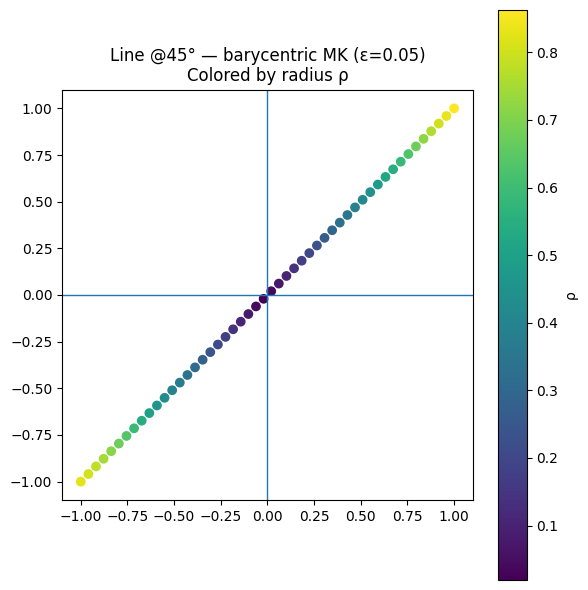

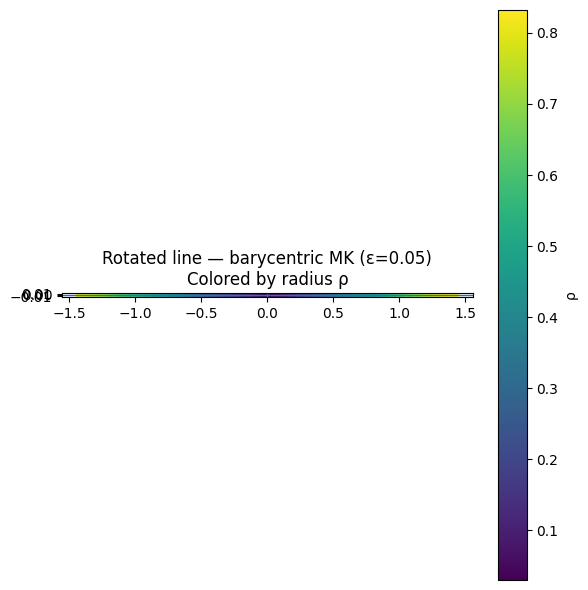

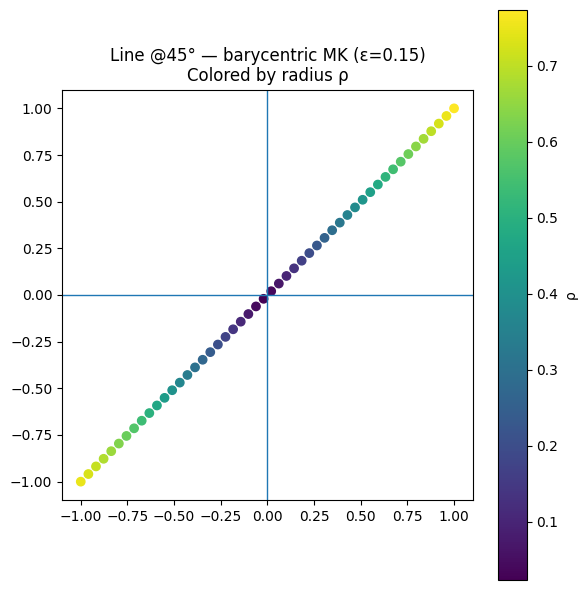

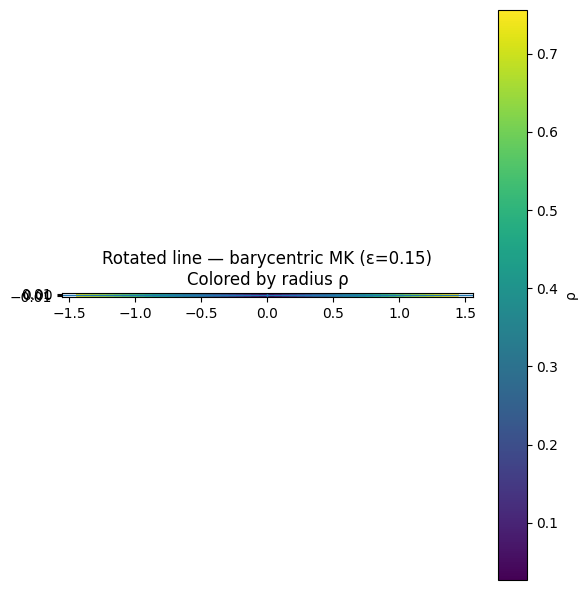

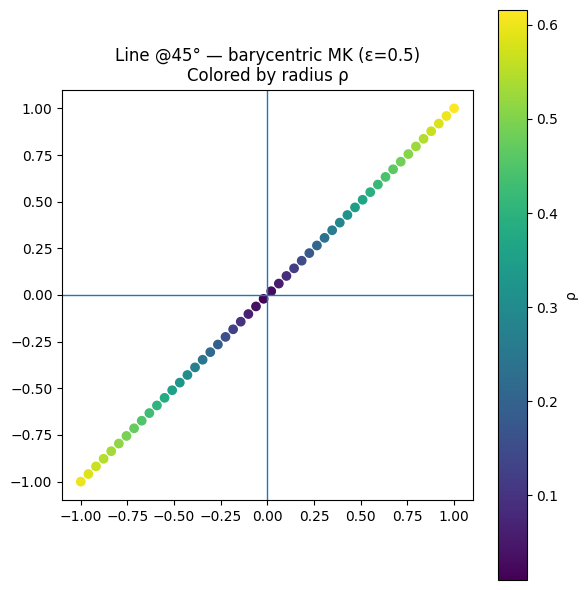

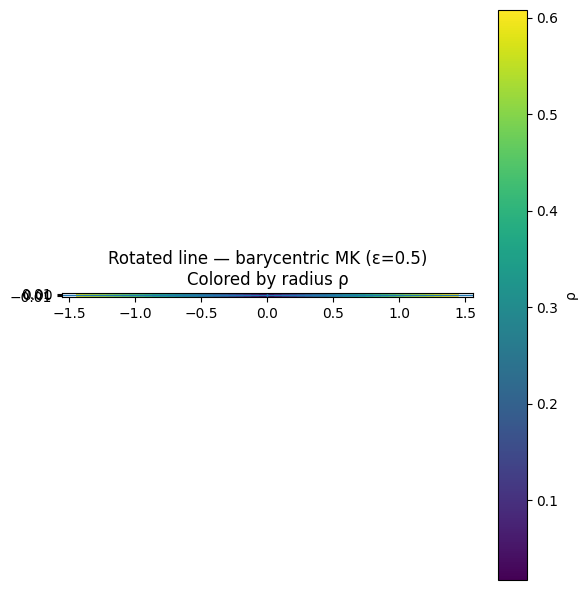

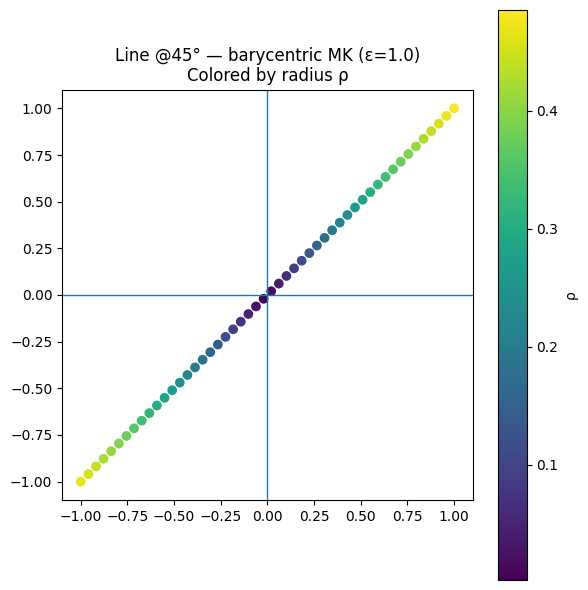

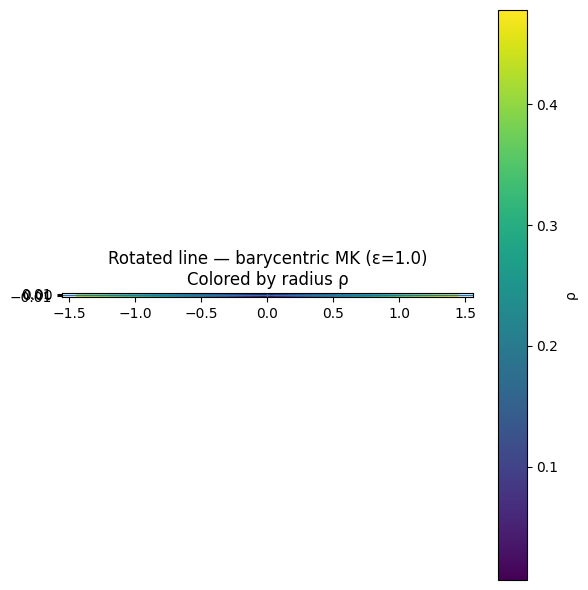

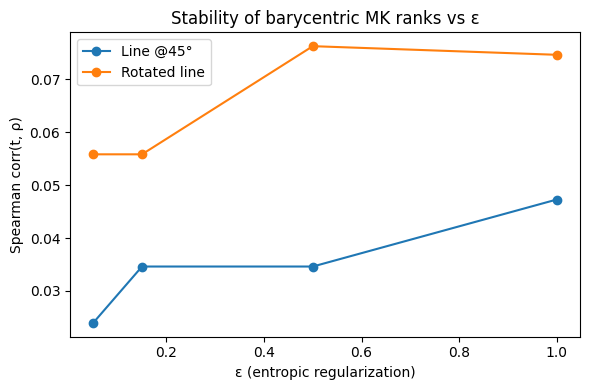

In [15]:
# Uniform masses
a = np.ones(n) / n
b = np.ones(n) / n

# Epsilon schedule
eps_list = [0.05, 0.15, 0.5, 1.0]

corr_line = []
corr_rot = []

# ---------- Run for each ε ----------
for eps in eps_list:
    # Costs
    C_line = cdist2(X_line, Y)
    C_rot  = cdist2(X_rot,  Y)

    # Sinkhorn
    P_line = sinkhorn(a, b, C_line, eps)
    P_rot  = sinkhorn(a, b, C_rot,  eps)

    # Barycentric projections: mapped points on ball
    U_line = barycentric(P_line, Y)
    U_rot  = barycentric(P_rot,  Y)

    # Rank radii
    rho_line = np.linalg.norm(U_line, axis=1)
    rho_rot  = np.linalg.norm(U_rot,  axis=1)

    # Correlations with the latent 1D parameter t
    corr_line.append(spearman_r(t, rho_line))
    corr_rot.append(spearman_r(t, rho_rot))

    # ---- Plot: original points colored by ρ (line) ----
    plt.figure(figsize=(6, 6))
    sc = plt.scatter(X_line[:,0], X_line[:,1], c=rho_line)
    plt.axhline(0, linewidth=1); plt.axvline(0, linewidth=1)
    set_equal_with_padding(plt.gca(), X_line)
    plt.title(f"Line @45° — barycentric MK (ε={eps})\nColored by radius ρ")
    cbar = plt.colorbar(sc)
    cbar.set_label("ρ")
    plt.tight_layout()
    # fname = f"/mnt/data/entropic_line_eps_{str(eps).replace('.','p')}.png"
    # plt.savefig(fname, dpi=150)
    plt.show()

    # ---- Plot: rotated line colored by ρ ----
    plt.figure(figsize=(6, 6))
    sc = plt.scatter(X_rot[:,0], X_rot[:,1], c=rho_rot)
    plt.axhline(0, linewidth=1); plt.axvline(0, linewidth=1)
    set_equal_with_padding(plt.gca(), X_rot)
    plt.title(f"Rotated line — barycentric MK (ε={eps})\nColored by radius ρ")
    cbar = plt.colorbar(sc)
    cbar.set_label("ρ")
    plt.tight_layout()
    # fname = f"/mnt/data/entropic_rot_eps_{str(eps).replace('.','p')}.png"
    # plt.savefig(fname, dpi=150)
    plt.show()

# ---------- Correlation vs ε chart ----------
plt.figure(figsize=(6, 4))
plt.plot(eps_list, corr_line, marker='o', label='Line @45°')
plt.plot(eps_list, corr_rot,  marker='o', label='Rotated line')
plt.xlabel("ε (entropic regularization)")
plt.ylabel("Spearman corr(t, ρ)")
plt.title("Stability of barycentric MK ranks vs ε")
plt.legend()
plt.tight_layout()
# plt.savefig('/mnt/data/entropic_corr_vs_eps.png', dpi=150)
plt.show()

# print("Saved per-ε figures for line and rotated line, and correlation chart at:")
# for eps in eps_list:
#     print(f" - /mnt/data/entropic_line_eps_{str(eps).replace('.','p')}.png")
#     print(f" - /mnt/data/entropic_rot_eps_{str(eps).replace('.','p')}.png")
# print(" - /mnt/data/entropic_corr_vs_eps.png")